# Homework 6

# Problem 1

Learn the hyperparameters of a Gaussian process kernel by Approximate Bayesian Computation. You will need a GP implementation (your own, or you can use scikit-learn or tinygp or whatever) in which you can make draws from the prior over functions. You will also need the small data set provided (on Discord) for this problem. And you will need to choose some broad prior over the two parameters of the Matérn 3/2 kernel. Make your convex distance function on the data directly, so that a trial function gets a good (low) score if it matches all N data points nearly exactly. Obtain a good posterior sampling with a few hundred ABC-generated posterior samples.

*Instructor note:* This problem is too hard!

*Bonus points:* Compare the posterior sampling you get from ABC to the true posterior, which you can compute the old-school way.

In [1]:
# skipped due to time constraints

# Problem 2

Re-do the regression of Problem Set 5, Problem 1, but now using a neural network. Either build your own, or else use a canned implementation from jax, pytorch, TensorFlow, or scikit-learn. Compare your results to your Problem Set 5 results. The deep learning results will be substantially better, right?

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm.auto import tqdm

In [3]:
# Load the data
with open('hw5_train.pkl', 'rb') as f:
    data_tr = pickle.load(f)
    
with open('hw5_val.pkl', 'rb') as f:
    data_va = pickle.load(f)

print("Training data:")
print("\n".join([f"  '{k}': {data_tr[k].shape}" for k in data_tr]))

print("Validation data:")
print("\n".join([f"  '{k}': {data_va[k].shape}" for k in data_va]))

Training data:
  'bp_coef': (4000, 55)
  'rp_coef': (4000, 55)
  'labels': (4000, 2)
Validation data:
  'bp_coef': (1000, 55)
  'rp_coef': (1000, 55)
  'labels': (1000, 2)


In [4]:
# Normalize the data
def normalize(data):
    rp, bp, teff = data['rp_coef'], data['bp_coef'], data['labels'][:, 0]
    rp /= rp[:, :1]
    bp /= rp[:, :1]
    
    X = np.concatenate((rp, bp), axis=1)
    y = teff
    return torch.tensor(X).float(), torch.tensor(y).float()

X_tr, y_tr = normalize(data_tr)
X_va, y_va = normalize(data_va)

print('Data shapes:')
print(f'  X_tr: {X_tr.shape}')
print(f'  y_tr: {y_tr.shape}')
print(f'  X_va: {X_va.shape}')
print(f'  y_va: {y_va.shape}')

Data shapes:
  X_tr: torch.Size([4000, 110])
  y_tr: torch.Size([4000])
  X_va: torch.Size([1000, 110])
  y_va: torch.Size([1000])


In [5]:
# Define our model (just a simple MLP)
class MLP(nn.Module):
    def __init__(self, input_size=110, output_size=1, layer_sizes=[]):
        super().__init__()
        
        assert input_size > 0
        assert output_size > 0
        
        lsizes = [input_size, *layer_sizes, output_size]
        self.layers = nn.ModuleList([
            nn.Linear(lsizes[i], lsizes[i+1])
            for i in range(len(lsizes) - 1)
        ])
        self.activ = F.relu
        
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activ(layer(x))
        return self.layers[-1](x)

In [6]:
# Define an experiment
def plot_training_curves(history):
    def mse_to_scaled_rms(mse, y):
        return np.sqrt(np.array(mse)) / np.mean(np.array(y))
    
    n_epochs = len(history['tr'])
    
    fig, axs = plt.subplots(3, 1, figsize=(12, 15))
    axs[0].plot(np.arange(n_epochs) + 1, history['tr'], label='Train')
    axs[0].plot(np.arange(n_epochs) + 1, history['va'], label='Validation')
    axs[0].set_ylabel('Loss value')
    axs[0].set_yscale('log')
    axs[0].legend(frameon=False)

    axs[1].plot(np.arange(n_epochs) + 1, mse_to_scaled_rms(history['tr'], y_tr), label='Train')
    axs[1].plot(np.arange(n_epochs) + 1, mse_to_scaled_rms(history['va'], y_va), label='Validation')
    axs[1].set_ylabel('Scaled RMS error')
    axs[1].set_yscale('log')
    axs[1].axhline(3.283e-02, label='Lin Reg (HW5)', color='grey', ls=':')
    axs[1].legend(frameon=False)

    axs[2].plot(np.arange(n_epochs) + 1, history['lr'])
    axs[2].set_xlabel('Number of epochs trained')
    axs[2].set_ylabel('Learning rate')
    axs[2].set_yscale('log')
    plt.show()

    
def experiment(layer_sizes=[], lr_0=1e-2, lr_step=100, lr_gamma=1.0, n_epochs=1_000, weight_decay=0):
    net = MLP(layer_sizes=layer_sizes)
    opt = optim.Adam(net.parameters(), lr=lr_0, weight_decay=0)
    sch = optim.lr_scheduler.StepLR(opt, lr_step, gamma=lr_gamma)
    lfn = nn.MSELoss()
    
    history = { 'tr': [], 'va': [], 'lr': [] }
    
    def train_step():
        net.train()
        opt.zero_grad()
        pred = net(X_tr).squeeze()
        loss = lfn(pred, y_tr)
        loss.backward()
        history['tr'].append(loss.item())
        history['lr'].append(opt.param_groups[0]['lr'])
        opt.step()
        sch.step()
        
    def val_step():
        net.eval()
        pred = net(X_va).squeeze()
        loss = lfn(pred, y_va)
        history['va'].append(loss.item())
        
    for i in tqdm(range(n_epochs), desc='Training', unit='epoch'):
        train_step()
        val_step()
        
    plot_training_curves(history)
    return net

First, let's try a really small model. No hidden layer, just straight linear connections from the input data to the output. In principle, this should be a loosely equivalent model to the linear regression from HW5.

Training:   0%|          | 0/10000 [00:00<?, ?epoch/s]

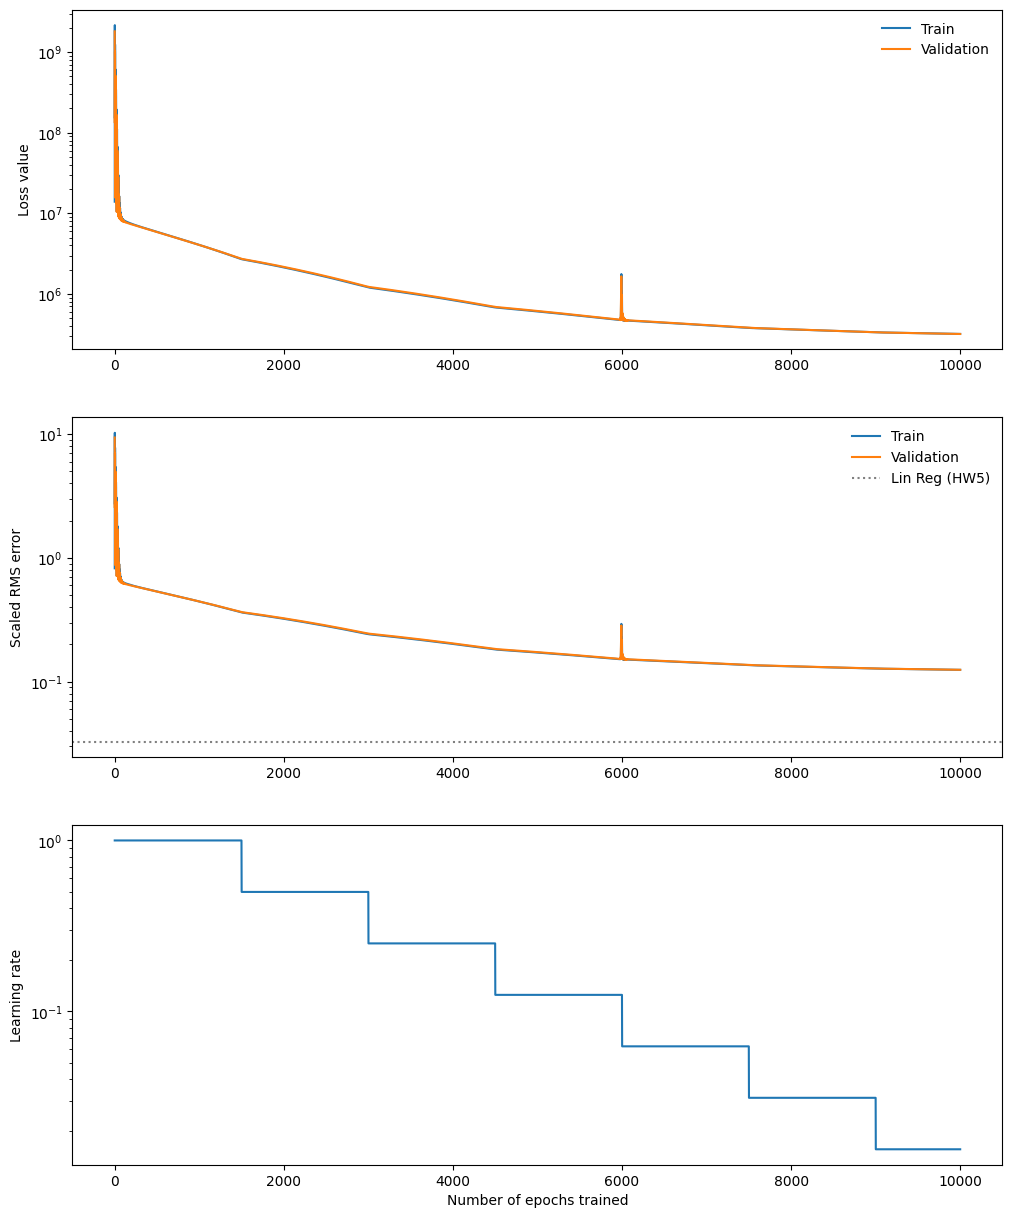

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=110, out_features=1, bias=True)
  )
)

In [7]:
experiment(
    layer_sizes=[],
    n_epochs=10_000,
    lr_0=1e0, lr_step=1500, lr_gamma=0.5
)

Surprisingly, we don't seem to be able to recreate the performance seen in HW5.

Next, let's try a somewhat larger model. One hidden layer around the same size as the input data.

Training:   0%|          | 0/10000 [00:00<?, ?epoch/s]

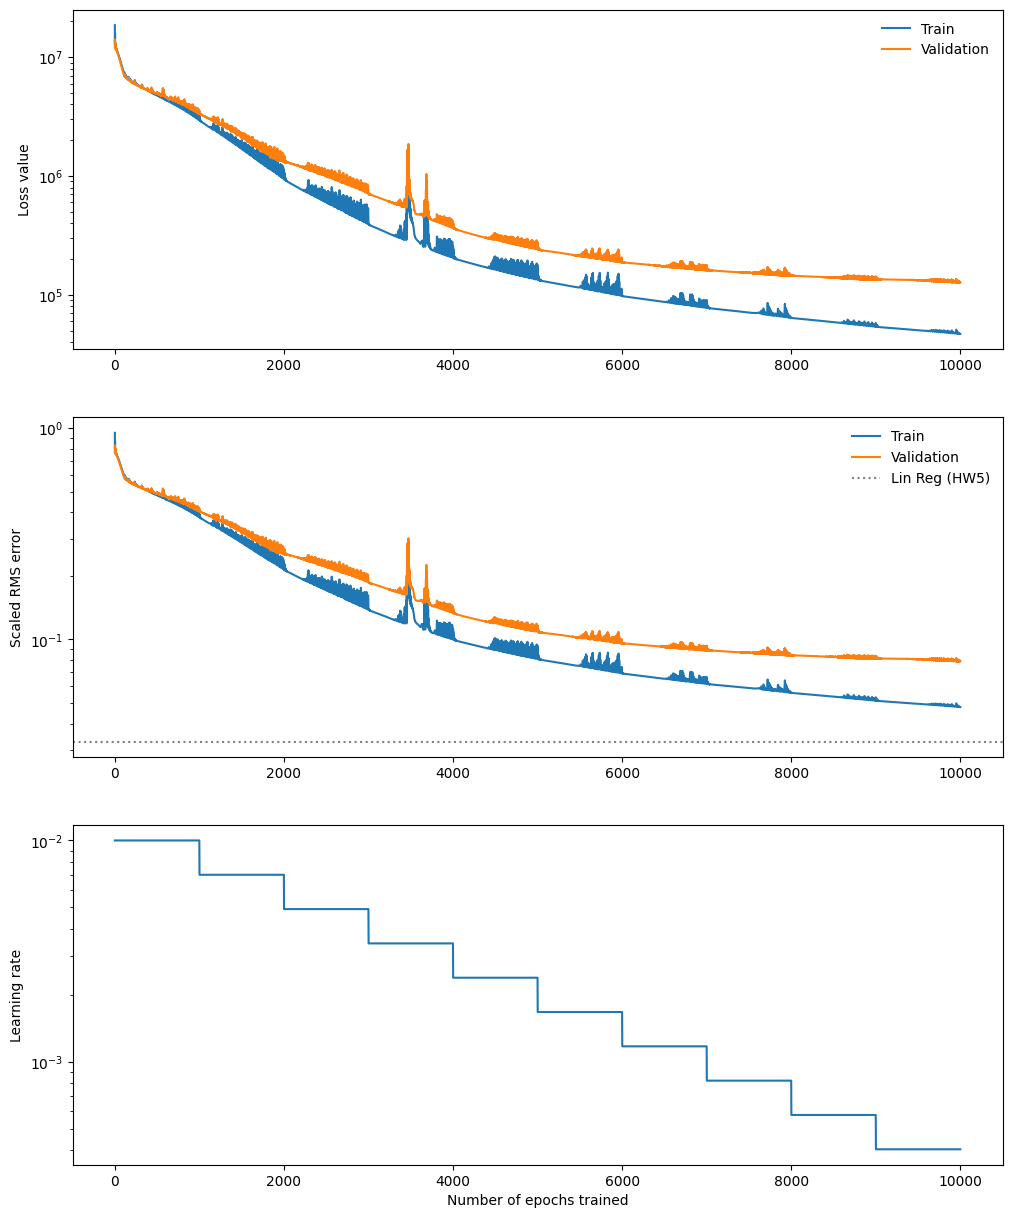

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=110, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [8]:
experiment(
    layer_sizes=[128],
    n_epochs=10_000,
    lr_0=1e-2, lr_step=1000, lr_gamma=0.7
)

And now for a much bigger model. Larger layer sizes, and several of them. I'm going to crank up the weight decay a little now to try to rein in the effects of the degeneracies.

Training:   0%|          | 0/1000 [00:00<?, ?epoch/s]

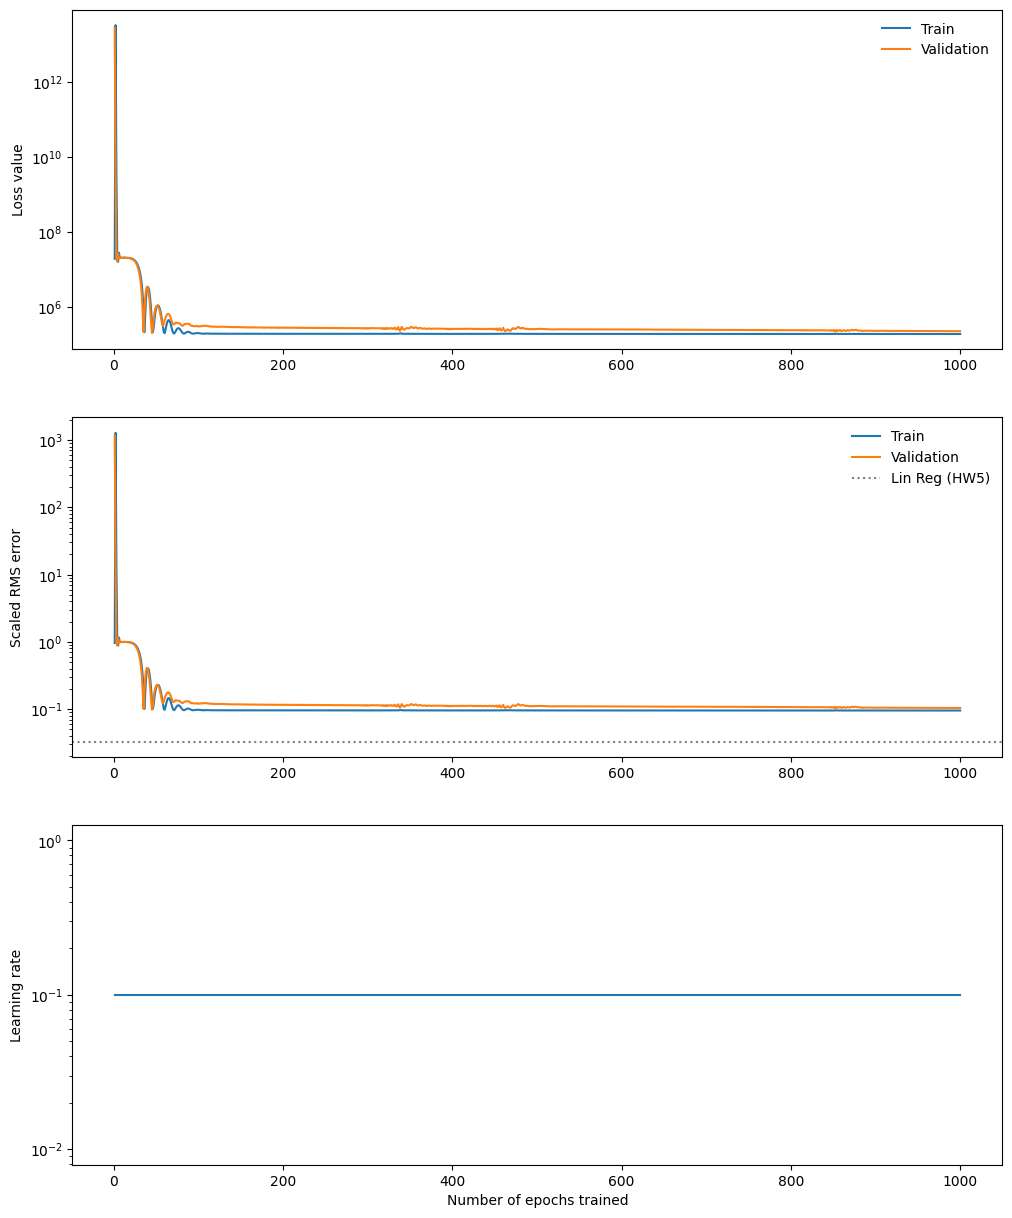

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=110, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [9]:
experiment(
    layer_sizes=[512, 256, 128],
    weight_decay=0.1,
    n_epochs=1_000,
    lr_0=1e-1, lr_step=1000, lr_gamma=1.0,
)

No matter what, we don't seem to be able to quite match the linear regression model with our neural networks.